# INFO 371 - Problem Set 3

Due: November 10 2024, 11:59 PM

### Instructions

Before beginning this assignment, please ensure you have access to a working instance of Jupyter Notebooks with Python 3.

1. First, replace the "YOUR NAME HERE" text in the next cell with your own full name. Any collaborators must also be listed in this cell.

2. Be sure to include well-documented (e.g. commented) code cells, figures, and clearly written text  explanations as necessary. Any figures should be clearly labeled and appropriately referenced within the text. Be sure that each visualization adds value to your written explanation; avoid redundancy – you do no need four different visualizations of the same pattern.

3. Collaboration on problem sets and labs is fun, useful, and encouraged. However, each student must turn in an individual write-up in their own words as well as code/work that is their own. Regardless of whether you work with others, what you turn in must be your own work; this includes code and interpretation of results. The names of all collaborators must be listed on each assignment. Do not copy-and-paste from other students’ responses or code - your code should never be on any other student's screen or machine.

4. All materials and resources that you use (with the exception of lecture slides) must be appropriately referenced within your assignment.

5. Partial credit will be awarded for each question for which a serious attempt at finding an answer has been shown. Students are *strongly* encouraged to attempt each question and document their reasoning process even if they cannot find the correct answer. 

6. After completing the assignment, ensure that your code can run from start to finish without issue. Restart the kernal and run all cells to double check.

Name: Trevor Tang

Collaborators: Salley Fang

## Introduction to the assignment

For this assignment, you will be using the [Ice Cream Dataset](https://www.kaggle.com/datasets/tysonpo/ice-cream-dataset). You can find more on the data by clicking the link. The dataset has two files, both of which are available on Canvas: products.csv, which contains information about individual ice cream flavors, and reviews.csv, which contains reviews from individuals.

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Part 1: Descriptive analysis (8 points)

### 1.1 Load the data (1 points)

Start by loading the product and the review data and storing them as pandas DataFrame objects. Ensure that the shape of the DataFrames matches the description from the website above.

In [218]:
product_data = pd.read_csv('products.csv')
review_data = pd.read_csv('reviews.csv')
product_data.shape, review_data.shape # Yes, the data matches the shape of the combined datasets on the Kaggle

((241, 8), (21674, 13))

### 1.2 Check for missing values

Are there any missing values in the reviews dataset? If so, which columns and how many? What about for the products dataset?

In [219]:
review_data.isna().sum()

brand              0
key                0
author           801
date               0
stars              0
title           5399
helpful_yes        0
helpful_no         0
text               0
taste          17409
ingredients    17409
texture        17409
likes          19379
dtype: int64

In the reviews dataset, there are 801 missing values in the author column, 5399 missing values in the title column, 17409 in the taste, ingredients, & texture column, and 19379 missing values in the likes column. It should be noted that the taste, ingredients, texture, and likes column have mostly non-null values for only haagen-daaz ice cream.

In [220]:
product_data.isna().sum()

brand             0
key               0
name              0
subhead         184
description       4
rating            0
rating_count      0
ingredients       0
dtype: int64

In the products dataset, there are 184 missing values in the subhead column, and 4 missing values in the description column

### 1.3 Product ratings histogram

Using the products dataset, create a histogram of the product ratings ranging from 1 to 5 (inclusive) with a bin width of 0.1. Use the brand of the ice cream as the color and stack the values across the brands for each bar (i.e. don't overlap them). 

What do you notice about the overall distribution of ratings and the ratings for the brands?

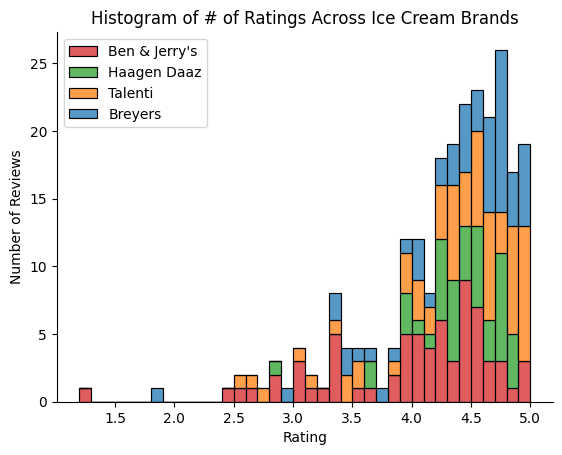

In [221]:
_ = sns.histplot(data=product_data, x='rating', binwidth=0.1, hue='brand', multiple='stack')
_ = plt.xlabel('Rating')
_ = plt.ylabel('Number of Reviews')
_ = plt.legend(labels=['Ben & Jerry\'s', 'Haagen Daaz', 'Talenti', 'Breyers'])
_ = plt.title('Histogram of # of Ratings Across Ice Cream Brands')
sns.despine()


The graph for rating counts seem to be left skewed overall and also for each brand. There also seems to be more higher ratings compared to lower ratings. 

### 1.4 Product ratings boxplot

Again using the products dataset, create a boxplot of the product ratings, separated by brand. Is there any brand that has notably better/worse ratings than the others? Is there any brand that has a notably larger range of values?

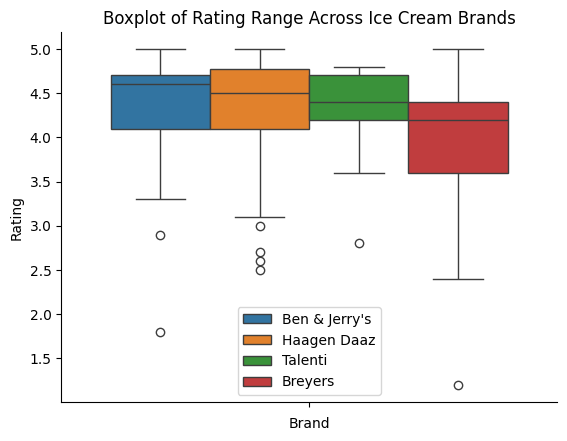

In [222]:
_ = sns.boxplot(data = product_data, y = 'rating', hue = 'brand')
_ = plt.xlabel('Brand')
_ = plt.ylabel('Rating')
_ = plt.legend(labels=['Ben & Jerry\'s', 'Haagen Daaz', 'Talenti', 'Breyers'])
_ = plt.title('Boxplot of Rating Range Across Ice Cream Brands')
sns.despine()

It seems that Breyers has worse ratings on average compared to the other brands, and that Ben and Jerry's has the highest average rating. However, Breyer does have the largest range compared to the other ice cream brands, so they may have a few flavors that are really good and some that are awful.

### 1.5 Star ratings barplot

Now, using the reviews dataset, create a barplot showing the brand of ice cream along the x-axis, the percent of reviews along the y-axis, and the number of stars given as a color. With this plot, each rectangle should indicate the percentage of reviews with a particular number of stars given to a brand. Organize your plot such that the total percentage across each of the four bars (one for each brand) is 100% and the number of stars in the reviews are ordered 1-5. 

Is there any brand with proportionally fewer 5-star reviews? What about proportionally more 1-star reviews?

(Hint: your final plot should resemble [this plot](https://r-graph-gallery.com/48-grouped-barplot-with-ggplot2_files/figure-html/thecode3-1.png), but instead of 'specie' along the x-axis, it should be brands and your colors should be the star ratings)

In [223]:
brand_review_counts = review_data.groupby(['brand', 'stars']).size().reset_index(name='count')
brand_review_totals = review_data.groupby('brand')['stars'].size().reset_index(name='total')

brand_review_graph_data = pd.merge(brand_review_counts, brand_review_totals, on='brand')
brand_review_graph_data['proportion'] = brand_review_graph_data['count'] / brand_review_graph_data['total']

brand_review_graph_data = brand_review_graph_data.pivot(index='brand', columns='stars', values='proportion')

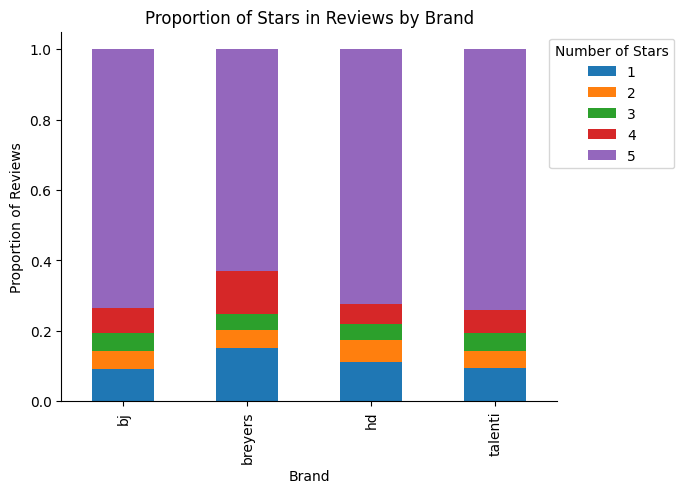

In [224]:
_ = brand_review_graph_data.plot(kind='bar', stacked=True, ax=plt.gca())
_ = plt.xlabel('Brand')
_ = plt.ylabel('Proportion of Reviews')
_ = plt.title('Proportion of Stars in Reviews by Brand')
_ = plt.legend(title='Number of Stars', bbox_to_anchor=(1.25, 1), loc='upper right')
sns.despine()

Ben & Jerry's, Haagen-Daaz, and Talenti seem to have a slight higher proportion of 5 star reviews than Breyers. Conversely, Breyers seems to proportionally have more 1 star reviews than the other brands.

## Part 2: Clustering

The goal of the next few sections is to cluster the products in the products dataset.


### 2.1 Calculate description lengths

To start, create a copy of the products dataset that you will use for Part 2 (we'll call this `part_2_dataset`). Remove any rows with a missing value for the product description from `part_2_dataset`. Then, add a column to `part_2_dataset` that indicates the length (in characters) of the description of the product. What is the final shape of `part_2_dataset`?

(Hint: make use of pandas.Series.str functions)

In [225]:
part_2_dataset = product_data.copy()

In [226]:
part_2_dataset = part_2_dataset[~part_2_dataset.description.isna()]

In [227]:
part_2_dataset['description length'] = part_2_dataset['description'].str.len()
part_2_dataset.shape

(237, 9)

The final shape of the dataset is 237 rows by 9 columns

### 2.2 Plot number of ratings vs description length

Next, plot the number of ratings for each description length in `part_2_dataset`. Use the brand as the color of each point. What do you see in the plot? Are there any "natural" clusters you notice amongst the data?

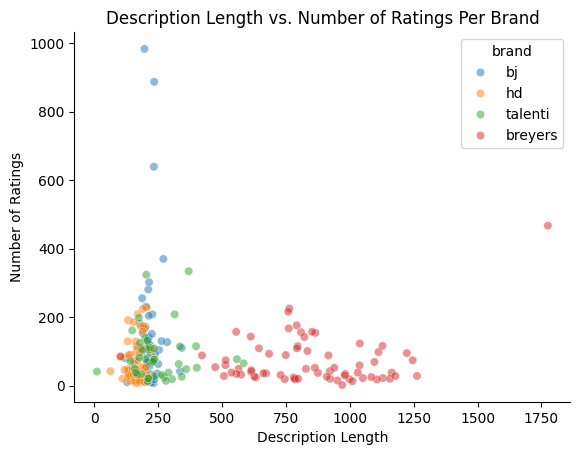

In [228]:
_ = sns.scatterplot(data = part_2_dataset, x = 'description length', y = 'rating_count', hue='brand', alpha=0.5)
_ = plt.xlabel('Description Length')
_ = plt.ylabel('Number of Ratings')
_ = plt.title('Description Length vs. Number of Ratings Per Brand')
sns.despine()

The plot does not seem to have any correlation. I can see 2 "natural" clusters within the data. The first one appears where three of the brands collide on the left side of the graph, while the other cluster is related to "breyers" ice cream on its own.

### 2.3 Find optimal number of clusters

Next, use K-means to find the optimal number of clusters when examining the number of ratings and the description length from the `part_2_dataset`. Iterate through 1-10 clusters and create a plot showing the number of clusters on the x-axis and the loss (dubbed "inertia" by sklearn) for each iteration along the y-axis. What do you think the optimal number of clusters is? 

In [229]:
from sklearn.cluster import KMeans

In [230]:
X_train = part_2_dataset[['rating_count', 'description length']]

In [231]:
inertia_data = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 11)
    kmeans.fit(X_train)
    inertia_data.append(kmeans.inertia_)
    
inertia_data

[28181380.24472574,
 7210475.508941473,
 4861890.528890825,
 4221859.029360931,
 2547654.203322771,
 1986217.3114620317,
 1758617.6059628269,
 1222533.517796966,
 1040744.2228156794,
 839854.1623076281]

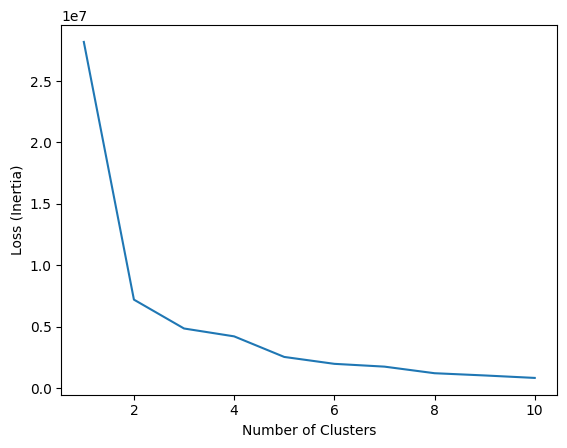

In [232]:
_ = sns.lineplot(x = np.arange(1, 11), y = inertia_data)
_ = plt.xlabel('Number of Clusters')
_ = plt.ylabel('Loss (Inertia)')

If we look at our graph, the elbow appears where n = 3 clusters. This means that our optimal number of clusters is likely 3.

### 2.4 Fit K-Means clusters

Next, use the optimal number of clusters that you found to fit K-means. Recreate your plot from 2.2 only now use the cluster number as the color. How do you think the clusters look? 

In [233]:
model = KMeans(n_clusters = 3, random_state = 11)
model.fit(X_train)

KMeans(n_clusters=3, random_state=11)

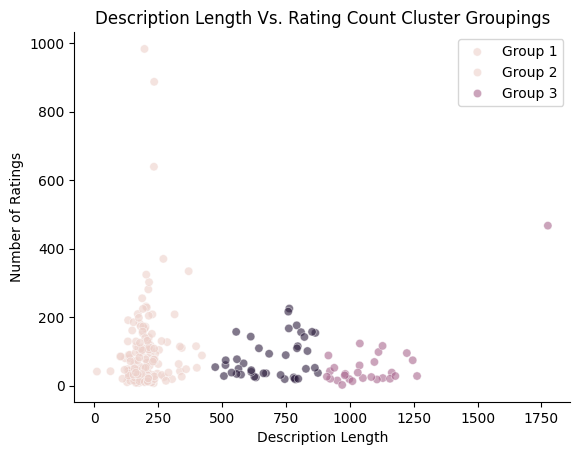

In [234]:
fitted_plot = sns.scatterplot(data = part_2_dataset,  x = 'description length', y = 'rating_count', hue=model.labels_, alpha=0.6)
_ = plt.xlabel('Description Length')
_ = plt.ylabel('Number of Ratings')
_ = plt.legend(labels=['Group 1', 'Group 2', 'Group 3'])
_ = plt.title('Description Length Vs. Rating Count Cluster Groupings')
sns.despine()

The clusters look pretty good. I can see clearly defined boundaries between each one, and there is little crossover between each grouping.

## Part 3: Predict Average Ratings

The goal of the next few sections is to design an experiment to predict the average rating for the products based on their ingredients.

### 3.1 Create term-document matrix

Use the original products dataset to create a term-document matrix of all the ingredients. For simplicity, treat every term in the list of ingredients as a separate entity (i.e. "skim milk" would be "skim" and "milk"). Use the following steps:
1. First isolate the ingredients column as a pandas Series 
2. Use pandas string functions to remove all non-alphabetic characters (numbers and punctuation included) except spaces (Hint: use [regular expressions](https://docs.python.org/3/howto/regex.html))
3. Then use the appropriate function from sklearn to create a term-document matrix (do not limit the terms based on term frequency or remove stop words)

How large is your term-document matrix? 

In [235]:
from sklearn.feature_extraction.text import CountVectorizer

In [236]:
ingredients = pd.Series(product_data['ingredients'])
ingredients.shape

(241,)

In [237]:
ingredients = ingredients.str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [238]:
vec = CountVectorizer()

In [239]:
vec.fit(ingredients)

CountVectorizer()

In [240]:
td_matrix = vec.transform(ingredients)
td_matrix

<241x332 sparse matrix of type '<class 'numpy.int64'>'
	with 7279 stored elements in Compressed Sparse Row format>

My term document matrix has 241 ingredients with 332 unique words.

### 3.2 Ingredient vocabulary

Which words are the most common amongst the ingredients (list the top 5)? Does this list make sense?

In [241]:
dense_ingredients = pd.DataFrame(td_matrix.todense(), columns=vec.get_feature_names_out())
dense_ingredients.head()

,acesulfame,acid,added,alkali,almond,almonds,and,andor,anhydrous,annatto,...,whites,whole,wine,with,xanthan,yeast,yellow,yolk,yolks,zest
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0


In [242]:
dense_ingredients.sum().sort_values(ascending = False)[:5]

sugar    541
milk     434
oil      371
cream    342
salt     283
dtype: int64

The top 5 words in our ingredients list are sugar, milk, oil, cream, and salt. This makes sense since sugar is virtually used in practically every flavor, and milk is the basis of ice cream. Oil, cream, and salt are also commonly used as basic ingredients of ice cream.

### 3.3 Create train-test split

Next, we'll use sklearn's naive Bayes implementation to create a naive Bayes classifier. Because this is a classifier, we'll need to first create classes. Using the products data, create a new variable named `high_rating` that has a value of _True_ when the rating is greater than 4 and _False_ otherwise. This will be the output (y) of your model. Then, create a 80/20 train-test split using your term-document matrix of ingredients as the input (X) to your model. What proportion of _Trues_ do you have in `high_rating` before the split? What proportion do have in your training data? In your test data?


In [243]:
from sklearn.model_selection import train_test_split

In [244]:
product_data['high_rating'] = np.where(product_data['rating'] > 4, True, False)

In [245]:
y = product_data['high_rating']
X = dense_ingredients

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=11)
X_train.shape, X_test.shape

((192, 332), (49, 332))

In [247]:
p_high_rating_actual = product_data['high_rating'].sum() / len(product_data['high_rating'])
p_high_rating_actual

0.7178423236514523

In [248]:
p_high_rating_training = y_train.sum() / len(y_train)
p_high_rating_training

0.6979166666666666

In [249]:
p_high_rating_test = y_test.sum() / len(y_test)
p_high_rating_test

0.7959183673469388

Before splitting, about 71.8% of our high ratings were true. After we split, our training data had about 70% of high ratings as true, and our test data had about 79.6% of high ratings as true.

### 3.4 Train a naive Bayes model

Train a naive Bayes model on your training data from 3.3. You do not need to optimize any hyperparameters. Use sklearn's `GaussianNB` implementation. What is the accuracy on the training data? On the test data? Show the confusion matrices for both training and test data. How does the model do?

In [250]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [251]:
model = GaussianNB()

In [252]:
model.fit(X_train, y_train)

GaussianNB()

In [253]:
preds_training = model.predict(X_train)
accuracy_score(y_train, preds_training)

0.6302083333333334

The accuracy for our training predictions is about 0.63

In [254]:
preds_test = model.predict(X_test)
accuracy_score(y_test, preds_test)

0.30612244897959184

The accuracy for our testing predictions is about 0.306

In [255]:
confusion_matrix(y_train, preds_training)

array([[58,  0],
       [71, 63]])

In [256]:
confusion_matrix(y_test, preds_test)

array([[ 3,  7],
       [27, 12]])

According to our data, the model is not that great. In our training data's confusion matrix, we have 71 incorrect predictions, and we have a similar observation in our testing data's confusion matrix with 34 incorrect predictions. 

### 3.5 Train a decision tree classifier

Use sklearn's decision tree implementation to train a classifier using your training and test data. How do the accuracy and confusion matrices compare to naive Bayes? (Note: you do not need to optimize hyperparameters)

In [257]:
from sklearn.tree import DecisionTreeClassifier

In [258]:
clf = DecisionTreeClassifier(random_state=11)

In [259]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

In [260]:
preds_training = clf.predict(X_train)
accuracy_score(y_train, preds_training)

1.0

The accuracy for our training predictions is exactly 100%, mostly because we are likely overfitting the data.

In [261]:
preds_test = clf.predict(X_test)
accuracy_score(y_test, preds_test)

0.6530612244897959

The accuracy for our testing predictions is about 0.653

In [262]:
confusion_matrix(y_train, preds_training)

array([[ 58,   0],
       [  0, 134]])

In [263]:
confusion_matrix(y_test, preds_test)

array([[ 6,  4],
       [13, 26]])

The confusion matrix for our training data makes sense as it the model predicted everything accurately. However, the confusion matrix for our test data shows that there were some incorrect predictions. Compared to our naive bayes model, the accuracy was about twice as much higher, so decision tree classifier might be the better model.

## Part 4: Predict Individual Ratings

The goal of this part of the problem set is to predict individual rating scores. 

### 4.1 Create term-document matrix

To start, create a term-document matrix using the text from the reviews data. Remove English stop words and only include words that appear in at least 1% of the reviews.

How large is your term-document matrix? 

In [264]:
vec = CountVectorizer(stop_words='english', min_df=0.01)

In [265]:
td_matrix = vec.fit_transform(review_data['text'])
td_matrix

<21674x323 sparse matrix of type '<class 'numpy.int64'>'
	with 248411 stored elements in Compressed Sparse Row format>

The term-document matrix consists of 21,674 documents, with 323 words that are not english stop words and appear in at least 1% of the reviews.

### 4.2 Create train-test split

Create a 80/20 train-test split using your term-document matrix from 4.1 as the input (X) to your model and the rating stars from the review data as your output (y). What do the distribution of star scores look like across your original, training, and test datasets? You do not need to show histograms but you may if you'd like.

In [266]:
dense_text = pd.DataFrame(td_matrix.todense(), columns=vec.get_feature_names_out())

In [267]:
X = dense_text
y = review_data['stars']

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=11)
X_train.shape, X_test.shape

((17339, 323), (4335, 323))

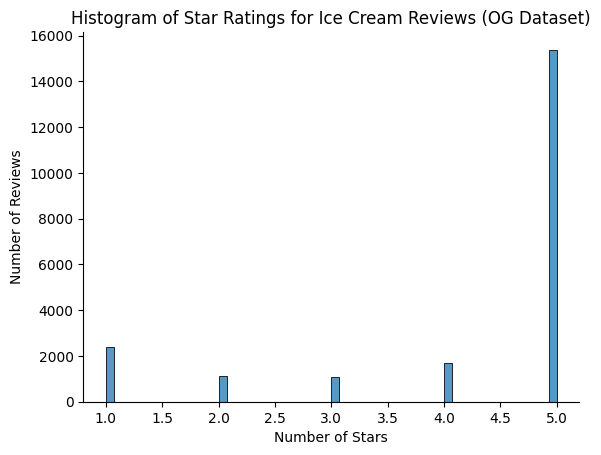

In [285]:
_ = sns.histplot(data = y) # Original dataset
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Reviews')
_ = plt.title('Histogram of Star Ratings for Ice Cream Reviews (OG Dataset)')
sns.despine()

In all three datasets there is a heavy presence of 5 star reviews (and in second place, 1 star) making each distribution left skewed. I only showed the original dataset as it is a good representative of how the distributions of the the y-train and y-test dataset look.

### 4.3 Train a decision tree classifier

Next, use sklearn's decision tree implementation to train a classifier using your training and test data. Use K-fold cross validation to optimize the 'max_depth' parameter of the model (use a maximum depth of 10). What is the accuracy of your model on the training and test set? What does the confusion matrix on the test set look like? Do you feel your model can successfully predict the star rating based on the text of the review?

In [270]:
from sklearn.model_selection import GridSearchCV

In [271]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=11), 
                           param_grid={'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                           scoring='accuracy', cv=5)


grid_search.fit(X_train, y_train)

best_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_ 

print("Depth:", best_depth)
print("Accuracy:", best_score)

Depth: 8
Accuracy: 0.7325104652899691


According to our grid search, the best depth with the highest accuracy (at 0.733) is 8 levels

In [272]:
clf = DecisionTreeClassifier(max_depth = 8)

In [273]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [274]:
preds_training = clf.predict(X_train)
accuracy_score(y_train, preds_training)

0.7463521541034662

The accuracy of our model on the training set is about 0.746

In [275]:
preds_test = clf.predict(X_test)
accuracy_score(y_test, preds_test)

0.7377162629757785

The accuracy of our model on the test set is about 0.737

In [276]:
confusion_matrix(y_test, preds_test)

array([[ 171,    5,    3,    1,  278],
       [  68,    0,    4,    2,  131],
       [  40,    2,    4,    0,  175],
       [  16,    1,    1,    0,  328],
       [  72,    2,    2,    6, 3023]])

The confusion matrix is quite accurate for our test set when it comes to predicting 1 or 5 star reviews. This is probably because our dataset has mostly 1 and 5 star ratings (based on the histogram above). However, since we have multiple outputs rather than a binary output, our model cannot predict all star ratings based on the text of the review, so it needs to be improved.

### 4.4 Examine the tree

Use sklearn's `plot_tree` function with your classifier to show the decision nodes at the first level (first two levels including the root). Which three words provide the greatest leverage for your tree based on this plot (i.e. which words are the decision points for the root and the first level)? Note that the tree plot may show indices - you'll have to map these indices to words in your vocabulary. Do these words make sense? Is there a text processing approach we discussed in class that may have further improved how our model fares?

In [277]:
from sklearn.tree import plot_tree

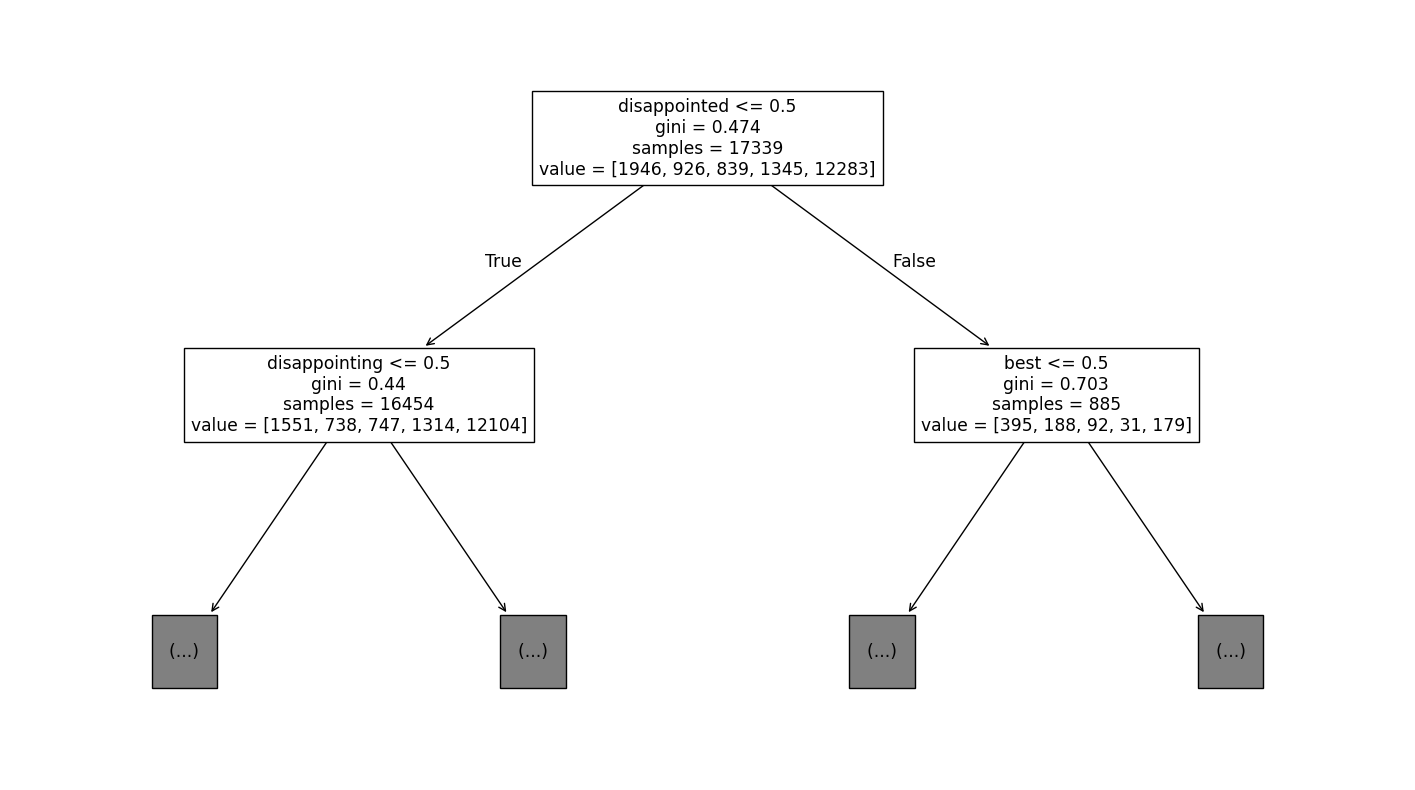

In [286]:
plt.figure(figsize=([18, 10]))
tree_plot = plot_tree(clf, max_depth = 1, feature_names=vec.get_feature_names_out())

The first three words are disappointed, disappointing, and best. This makes sense since it describes the first reaction that someone may have when trying a flavor. Some text processing approaches we can use to further improve our model are stemming and lemmatizing (to get the base words i.e., we have disappointed and disappointing in our tree) or use tokens with more than one word (i.e., bigrams) to get better context for our tree.